# Zadanie 6

Celem ćwiczenia jest implementacja algorytmu Q-learning.

Następnie należy stworzyć agenta rozwiązującego problem [Taxi](https://gymnasium.farama.org/environments/toy_text/taxi/). Problem dostępny jest w pakiecie **gym**.

Punktacja (max 8 pkt):
- Implementacja algorytmu Q-learning. [3 pkt]
- Eksperymenty dla różnych wartości hiperparametrów [2 pkt]
- Jakość kodu [1.5 pkt]
- Wnioski [1.5 pkt]


In [6]:
import numpy as np
import gymnasium as gym
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from time import sleep


In [7]:
# Interfejs

from collections import defaultdict
from random import sample


class QLearningSolver:
    """Class containing the Q-learning algorithm that might be used for different discrete environments."""
    def __init__(self,
                 observation_space:int,
                 action_space:int,
                 learning_rate:float=0.1,
                 gamma:float=0.9,
                 epsilon:float=0.1,
                 ):
        self.observation_space = observation_space
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_values = defaultdict(lambda : np.zeros(action_space))
        self.training_error = []

    def __call__(self, state:np.ndarray, action:np.ndarray) -> np.ndarray:
        """Return Q-value of given state and action."""
        return self.q_values.get(state)[action]

    def update(self, state:np.ndarray, action:np.ndarray, reward:float) -> None:
        """Update Q-value of given state and action."""
        future_q_value = max(self.q_values.get(state)) if self.q_values.get(state) is not None else 0
        diff = reward + self.gamma * future_q_value - self.q_values[state][action]
        self.q_values[state][action] =  self.q_values[state][action] + self.learning_rate * diff
        self.training_error.append(reward)

    def get_best_action(self, state:np.ndarray) -> np.ndarray:
        """Return action that maximizes Q-value for a given state."""
        if np.random.random() < self.epsilon:
            return int(random.sample(range(self.action_space), k=1)[0])
        else:
            return np.argmax(self.q_values[state])

    def __repr__(self):
        """Elegant representation of Q-learning solver."""
        pass

    def __str__(self):
        return self.__repr__()

In [8]:
env = gym.make('Taxi-v3')

In [50]:
episodes = 5000
def run(env, agent):
    for episode in tqdm(range(episodes)):
        obs, info = env.reset()
        done = False
        while not done:
            action = agent.get_best_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            agent.update(obs, action, reward)
            done = terminated or truncated
            obs = next_obs

In [51]:
lr_change = [
    [0.01, 0.9, 0.1],
    [0.1, 0.9, 0.1],
    [0.2, 0.9, 0.1],
    [0.3, 0.9, 0.1],
]
gamma_change = [
    [0.01, 0.8 ,0.1],
    [0.01, 0.85, 0.1],
    [0.01, 0.9, 0.1],
    [0.01, 0.95, 0.1]
]
epsilon_change = [
    [0.01, 0.9, 0.1],
    [0.01, 0.9, 0.15],
    [0.01, 0.9, 0.2],
    [0.01, 0.9, 0.25]
]
agents = []
errors = []
arguments = [lr_change, gamma_change, epsilon_change]
for change in arguments:
    for args in change:
        agents.append(QLearningSolver(env.observation_space, env.action_space.n, *args))
for agent in agents:
    run(env, agent)

100%|██████████| 5000/5000 [01:04<00:00, 77.45it/s] 


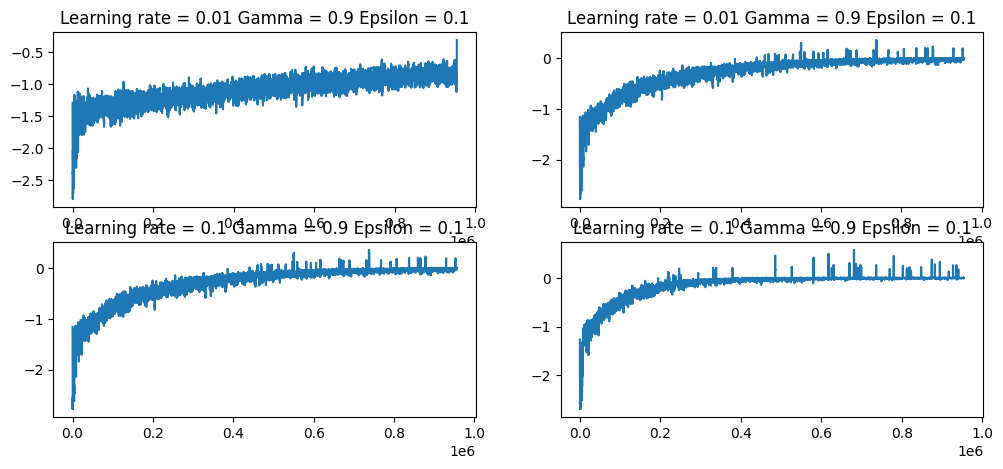

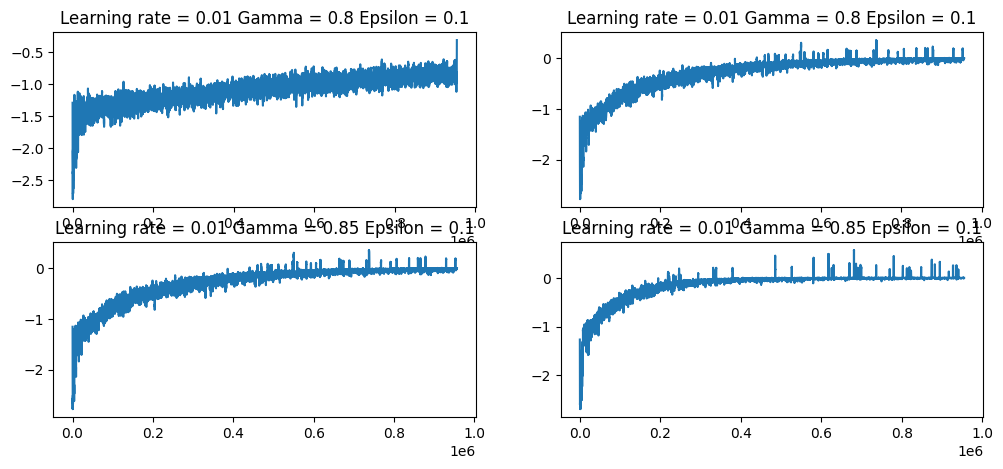

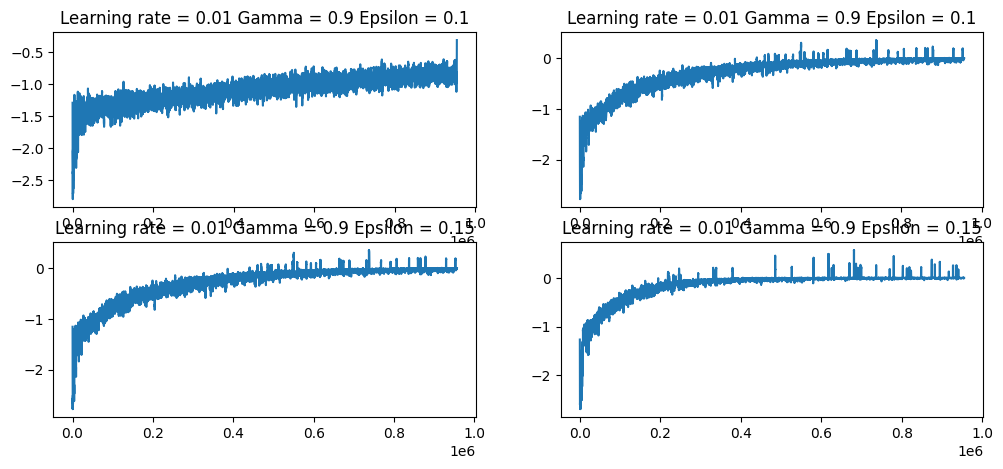

In [73]:
arguments = [lr_change, gamma_change, epsilon_change]
rolling_length = 500
for idx in range(3):
    fig, axs = plt.subplots(2, 2,figsize=(12, 5))
    for i in range(2):
        for j in range(2):  
            training_error_moving_average = (
                np.convolve(np.array(agents[i+j].training_error), np.ones(rolling_length), mode="same")
                / rolling_length
            )
            axs[i, j].set_title(f"Learning rate = {arguments[idx][i][0]} Gamma = {arguments[idx][i][1]} Epsilon = {arguments[idx][i][2]}")
            axs[i, j].plot(range(len(training_error_moving_average)), training_error_moving_average)
    plt.show()

100%|██████████| 5000/5000 [00:55<00:00, 89.54it/s] 


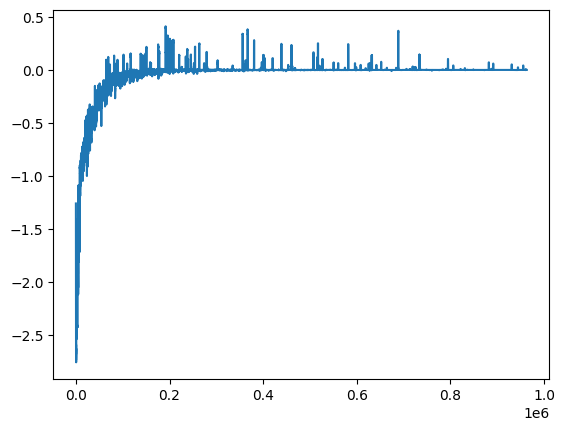

In [71]:
agent_a = QLearningSolver(env.observation_space, env.action_space.n, 0.6, 0.9, 0.3)
run(env, agent_a)
training_error_moving_average = (
            np.convolve(np.array(agent_a.training_error), np.ones(rolling_length), mode="same")
            / rolling_length
        )
plt.plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.show()

# Uruchomienie

In [72]:
streets = gym.make("Taxi-v3", render_mode="human").env
while True:
    obs, info = streets.reset()
    done = False
    while not done:
        sleep(0.1)
        action = agents[0].get_best_action(obs)
        next_obs, reward, terminated, truncated, info = streets.step(action)
        agents[0].update(obs, action, reward)
        done = terminated or truncated
        obs = next_obs
    

KeyboardInterrupt: 

# Wnioski

- Im większy learning_rate to szybciej się ucze, ale nie wpływa na jakość uczenia się
- Według wykresów, zmiana gamma nie powoduje wielkich zmian
- Przy większych epsilon agent robi więcej błędów
- Przy użyciu epsilon decay z czasem agent zmniejsza ilość eksploracji